# Fitting Multiple Change-point Models for Time Series Data
--
Fan Li (fl53)

In [1]:
### configuration
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as la

%matplotlib inline
%precision 4
plt.style.use('ggplot')

##  Background

This project is based on the paper "Estimation and comparison pf multiple change-point models" by Chib (1998).

Change-point models are proposed to detect possible heterogeneity in a stochatic process. Formally, suppose we have observed a set observations indexed by time $\{X\}_{t=1}^T$, where $\{X\}_{t=1}^{t_k}$ are identically distributed according to $\mathcal{F}_0$, and $\{X\}_{t=t_k+1}^T$ by $\mathcal{F}_1$. If $\mathcal{F}_0\neq \mathcal{F}_1$, we call the time point $t=t_k$ a change point, which is unknown and of interest in practice. In the above process, only a single change point exists. In other complex models, there could be more than one such change points underlying the heterogeneity. A major focus of change-point models is to determine the totality of such change-points, revealing the dynamics of an ongoing process. The application of change-point models encompass a broad spectrum, such as control theory, time series and reliability analysis.

Based on how the observations are collected, change-point models are classified as sequential and posteriori detection models. Sequential models updates the estimates along with the collection, while the posteriori models analyzed the data post to the collection. Based on model assumptions, we have parametric and non-parametric detection models. Further, models are classified into dicrete- and continuous-time (state) detection models, by the nature of the stochastic process. In this project, we'll mainly looks at the discrete-time discrete-state Markov process with a multiple change-point posetriori detection model. To follow the ideas of the paper (Chib 1998), we will consider parametric models. We will also compare with more up-to-date nonparametric models in application of the algorithm to the real data sets.

### Parameterization

We state the model formally as the following. Suppose we observe a time series $Y_n=\{y_1,\ldots,y_n\}$ where the distribution of $y_t|Y_{t-1}$ depends on the unknown parameter $\xi_t$. Given a collection of unknown time of change-point $\Upsilon_m=\{\tau_1,\ldots,\tau_m\}$ and let $\tau_0=0$, $\tau_{m+1}=n$, we further assume the regime $\xi_t$ depends on the the interval determined by consectutive change-point time:

$$\xi_t=\begin{cases} \theta_1 &\mbox{if } \tau_0 < t \leq \tau_1, \\ 
\theta_2 &\mbox{if } \tau_1 < t \leq \tau_2,\\
\vdots &\vdots\\
\theta_m &\mbox{if } \tau_{m_1} < t \leq \tau_m,\\
\theta_{m+1} &\mbox{if } \tau_{m} < t \leq \tau_{m+1}. \end{cases}$$

Further let $Y_t=(y_1,\ldots,y_t)$ indicate the history up to time $t$ and $Y^{t,t'}=(y_t,\ldots,y_{t'})$ the history from $t$ to $t'$, then the joint likelihood of the time series is expressed as
$$\mathcal{L}(Y_n|\Theta,\Upsilon_m)=\prod_{k=1}^{m+1}f(Y^{\tau_{k-1}+1,\tau_k}|Y_{\tau_{k-1},\theta_k,\tau_k}).$$

Given the prior $\pi(\Theta,\Upsilon)$, the posterior inference can be carried out via Morkov Chain Monte Carlo (MCMC). However, the conventional method which samples $\tau_k$ one at a time is far from ideal due to non-existence of appropriate proposal densities. And the associated timing of computation is also an issue. The method proposed by Chib utilized a new parameterization that reproduces the exact same model with a set of augmented latent state variables (underlying regimes) $S_n=\{s_t\}_{t=1}^n\in\{1,\ldots,m+1\}^n$. Namely, the regime variable $s_t=k$ indicates that the generating distribution of $y_t$ is $f(y_t|Y_{t-1},\theta_k)$. Resembling the idea of a hidden Markov model (HMM), we model the state variables with a one-step ahead transition probability matrix 

$$P=\left(\begin{array}{cccccc}
p_{11} & p_{12} & 0 & \ldots & 0 \\
0 & p_{22} & p_{23} & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\ldots & 0 & 0 & p_{mm} & p_{m,m+1} \\
0 & 0 & \ldots & 0 & 1 \end{array} \right),$$

where $p_{ij}=\mathcal{P}(s_t=j|s_t=i)$ as in any conventional Markov process.

## Updating Model Parameters

In this section, we will focus on discussing how to update all the model parameters using the above parameterization. This consititutes the most important part of the algorithm. Above all, the posterior estimates (samples) of latent states, probability of each observation within a certain regime, underlying regime values and transition probablities are the keys to uncover a process. Second, in computing model evidence (what follows in the next section), these updates are also required. In this section, we first introduce a scan of the algorithm. Then we compared two versions of updates, a naive one programmed at the start of the project and an optimized one revised later on. A series of unit tests (including boundary cases) are developed to make sure that the update function return appropriate results, and the chain moves on well. 

### Posterior Inference for Model Parameters

With data augmentation, the posterior inference becomes tractable. We proceed in the following order:

- Update the augmented state variables $S_n$:

Let $S_t=(s_1\ldots,s_t)$ denote the state history up to time $t$ and $S^{t+1}=\{s_{t+1},\ldots,s_{n}\}$ the history from time $t+1$ until the end, and similarly for $Y_t$ and $Y^{t+1}$. The only way shown (Chib 1993) to derive the sampler with closed-form expressions is to write the joint posterior full conditional in the reverse order as:

$$\prod_{t=1}^{n-1} p(s_t|Y_n,S^{t+1},\Theta,P).$$

Fixing $s_n=m+1$, the sampler generates $s_t$ from $p(s_t|Y_n,S^{t+1},\Theta,P)$ from $t=n-1$ until $t=1$. Chib showed that 

$$p(s_t|Y_n,S^{t+1},\Theta,P)\propto p(s_t|Y_t,\Theta,P)p(s_{t+1}|s_t,P),$$

where the first item is the univariate conditional posterior of the state variable at time $t$, and the last item is the transition probability directly available from the current update. Note that $p(s_t|Y_n,S^{t+1},\Theta,P)$ only have point masses on the consecutive pairs given the value of $s_{t+1}$, so the calculation of the normalization constant is straightforward. Further, given $p(s_{t-1}=l|Y_{t-1},\Theta,P)$,

$$p(s_t=k|Y_t,\Theta,P)=\frac{p(s_t=k|Y_{t-1},\Theta,P)f(y_t|Y_{t-1},\theta_k)}{\sum_{l=1}^{m+1} p(s_t=l|Y_{t-1},\Theta,P)f(y_t|Y_{t-1},\theta_l)},$$

where
$$p(s_t=l|Y_{t-1},\Theta,P)=\sum_{l=k-1}^k p_{lk}p(s_{t-1}=l|Y_{t-1},\Theta,P),$$

for $k=1,\ldots,m$. Specifically, $p(s_1=1|Y_{0},\Theta,P)=1$ is initiated, and a recursive calcation is performed to obtain all values of $p(s_t=k|Y_t,\Theta,P)$ and $p(s_t=l|Y_{t-1},\Theta,P)$. Finally, the backward sampling procedure is used to generate a sample of latent states.

- Update transition matrix $P|S_n$:

First note that there is only a single unknown parameter in each row of $P$, say the diagonal element $p_{ii}$. Suppose we assign conjugate Beta$(a,b)$ prior independently for $p_{ii}$, where $a,b$ are chosen according to prior belief about the mean duration of each regime. The full conditional is given by 

$$p_{ii}|\cdot \sim \text{Beta}(a+n_{ii},b+n_{i,i+1}),\qquad\qquad\forall i\in \{1,\ldots,m\},$$

where $n_{ij}$ is the number of one-step transitions from state $i$ to state $j$ in the current sequence $S_n$.

- Update the model parameters $\Theta|Y_n,S_n,P$:

Since we are dealing with parametric models, so $\Theta$ is model-specific. We will present more details on derivation of the full conditionals in subsequent sections for specific models.

### Code Profiling and Optimization

An early (naive) version of the update functions and a later (optimized) version are contrasted. The naive version handles each update piece by piece, without vectorization and simultaneous updates for the intermediate steps. The following example uses a line profiler to identify the possible bottlenecks of the naive code (updating the latent states). 

In [2]:
import Optimization.NaiveSourceCode as nsc
import Optimization.OptimizedSourceCode as osc

In [3]:
np.random.seed(1234)

# Specify test data
y = np.loadtxt("Data/data_test")
theta_true = np.array([1., 3.])
n, m = len(y), 1
a, b = 8., 0.1
c, d = 2., 100.

# Inits - parameters
theta = np.array([2., 4.])
theta_star = theta_true
sigma = np.sqrt(3.0)
s = np.repeat(np.array([0., 1.]), np.array([70, 80]))

# Inits - useful quantities                           
Ptran = np.zeros((m + 1, m + 1))
Ptran[-1, -1] = 1
for j in range(m):
    Ptran[j, j] = 0.875
    Ptran[j, j+1] = 1 - Ptran[j, j]
Ptran_star = Ptran

In [4]:
%load_ext line_profiler

In [5]:
# Suppress the Lengthy output
lstats = %lprun -r -f nsc.update_Sn_naive nsc.update_Sn_naive(y, n, m, Ptran, theta, s)
# lstats.print_stats()

Possible bottlenecks include line 42 (update the posterior probability of latent states), and line 52/53 (updating sampling pmfs). In the optimized code, we explored vectorization and joint update for intermediate steps extensively, resulting in efficiency gain. The line profiler is not shown to avoid lengthy output, but could be found in the "Optimization" folder. Before we show the constrast in time for the two versions of codes, we offer several comments. First, the nature of the algorithm (MCMC) determines that each update depends on the previous one, so parallel computing would not help too much in improving efficiency. Second, improving each function for a certain amount will help saving much time since the algorithm uses eachh uopdate thousands of times (runs), and is indeed our focus here. Third, a possble extension to C code is promising, but faces the challenge of entensive use with known parametric sampling models. Admittedly, we will look at an alternative model in R, whose functions resort to "Rcpp", and is quite fast in time. But the majority of difference comes from the essence of the sampling procedures (will be discussed later). We feel confident that this optimization in Python is fast enough for Chib's algorithm. The time-consuming recursive(forward-backward) updates come as a price with the nature of this inference. We show the improved efficiency below for all three major update functions. 

In [6]:
%timeit -n2 -r4 nsc.update_Sn_naive(y, n, m, Ptran, theta, s)
%timeit -n2 -r4 osc.update_Sn_optimized(y, n, m, Ptran, theta, s)

2 loops, best of 4: 38.9 ms per loop
2 loops, best of 4: 26.7 ms per loop


In [7]:
%timeit -n2 -r4 nsc.update_P_naive(a, b, n, m, s, Ptran_star)
%timeit -n2 -r4 osc.update_P_optimized(a, b, n, m, s, Ptran_star)

2 loops, best of 4: 675 µs per loop
2 loops, best of 4: 438 µs per loop


In [8]:
nk, Ptran, f_Ptran_star = nsc.update_P_naive(a, b, n, m, s, Ptran_star) 
%timeit -n2 -r4 nsc.update_Theta_naive(c, d, m, y, s, nk, theta_star)
%timeit -n2 -r4 osc.update_Theta_optimized(c, d, m, y, s, nk, theta_star)

2 loops, best of 4: 471 µs per loop
2 loops, best of 4: 340 µs per loop


From the above output, we see that the optimized code shows quite a bit of improvement. Optimization saves one third of the original time in updating the latent states, almost half of the original time in updating the transition matrix and almost one fourth of the original time in updating the means for a Gaussian time series.

### Unit Tests for the Optimized Code

The following paragraph is a draft of the each unit test file for our major functions. 

- Test for updating the latent states $s_{t}$ for each $t$:

 - For the recursive calculation of quantities (like the HMM forward-backward steps), check whether the one-step ahead predictive probabilities satisfy
   
   $$\sum_{l=1}^{m+1} p(s_{t-1}=l|Y_{t-1},\Theta,P)=1\qquad\forall\quad t\in\{2,\ldots,n+1\},$$
   
 - Further check the posterior conditional masses
 
   $$\sum_{k=1}^{m+1} p(s_t=k|Y_t,\Theta,P)=1\qquad\forall\quad t\in\{1,\ldots,n\},$$
  
 - Check whether the updated sequence $\{s_t\}$ is properly ordered such that
   
   $$s_{t-1} \leq s_{t}\qquad\forall~t\in \{2,\ldots,n\}$$
   
 - Check the error message if the input transition matrix contains a negative probability entry (only for single updates).

- Test for updating transition probability $p_{ii}$ 

 - assess whether each update is a valid posterior probability mass between $(0,1)$;
 
 - assess whether the numbers of counts (for each states) fall into the range exactly between $0$ and $n$, and whether they sum to $n$.

We drafted four series of tests, two for single updates and two for iterative updates. The single updates only look at a slice of update while the iterative updates examine at the end of $10$ iterations. Within each scenario, the two series of tests are for fitting single change-point model ($m=1$) and multiple change-point model ($m=2$) to make sure that the functions can well handle models with different complexity. Each series of tests contain $6$ or $5$ tests outlined above. We have in total $22$ tests. The following line execute the all tests. 

In [9]:
! py.test "UnitTest/."

============================= test session starts ==============================
platform linux2 -- Python 2.7.9 -- py-1.4.25 -- pytest-2.6.3
collected 22 items 

UnitTest/test_mcmc_sampling_one_ChangePoint_iterative_steps.py .....
UnitTest/test_mcmc_sampling_one_ChangePoint_single_step.py ......
UnitTest/test_mcmc_sampling_two_ChangePoint_iterative_steps.py .....
UnitTest/test_mcmc_sampling_two_ChangePoint_single_step.py ......

========================== 22 passed in 3.14 seconds ===========================


## Computing Model Evidence

One of the interesting features of Chib's algorithm is the availability of model evidence, i.e., marginal likelihood (Bayes factor). The idea is to fit several multiple change-point models, compute their marginal likelihood and make decisions on which model to choose based on the Bayes factor. In Bayesian inference, the Bayes factor provides a systematic support on model selection decisions. But usually this is hard to compute. Direct computation involves intractable integrations. With MCMC output, we can make use the posterior samples and approximate the marginal likelihood using these outputs. We embedded this computation into our functions to make them available along with the posterior samples. 

### Approximating the Maximum Likelihood Coordinates

Given a model with $r$ change points $M_r$, the marginal likelihood is

$$m(Y_n|M_r)=\frac{f(Y_n|M_r,\Theta^{*},P^{*})\pi(\Theta^{*},P^{*}|M_r)}{\pi(\Theta^{*},P^{*}|Y_n,M_r)},$$

from the Bayes' theorem. In the equation, $\psi^{*}=(\Theta^{*},P^{*})$ is any point within the parameter space in theory. In numerical approximation, the best practice is to choose the coordinate close to the posterior mode, which prevents the approximation from numerical underflow. The MCMC will automatically reasonable estimates for these values, but to reuse this values within each iteration of the chain, we need to start a new MCMC, which is quite expensive in computing. The paper describes the procedures to make these estimates available using Monte Carlo Expectation Maximization (MCEM). This methods approximates the maximum likelihood estimates. In the E-step, $N$ samples of $S_n,j(j\leq N)$ are drawn from $p(S_n|Y_n,\psi^{\text{current}})$, and the expected log-likelihood function is computed as

$$\hat{Q}(\psi)=\frac{1}{N}\sum_{j=1}^N \log\{f(Y_n,S_{n,j}|\psi)\}=\frac{1}{N}\sum_{j=1}^N \{\log f(Y_n|S_{n,j},\Theta)+\log f(S_{n,j}|P) \}.$$

Clearly, this function separates the component of model parameters and transition matrix into two disjoint pieces. The M-step can be carried out via

$$\hat{p}_{ii}=\frac{\sum_{j=1}^N n_{ii,j}}{\sum_{j=1}^N(n_{ii,j}+1)},\qquad i=1,\ldots,n,$$

where $n_{ii,j}$ is the number of transitions from state $i$ to state $i$ in sample $S_{n,j}=\{s_{1,j},\ldots,s_{n,j}\}$.  For the applications in our project (or more generally models with sample average as the MLE),

$$\hat{\theta}_k=\frac{\sum_{j=1}^N\sum_{t=1}^n y_t\mathbb{I}(s_{t,j}=k)}{\sum_{j=1}^N\sum_{t=1}^n \mathbb{I}(s_{t,j}=k)}.$$

To save the computational time, we follow the idea of the paper and set the Monte Carlo replicates $N$ to $1$ initially and gradually increase to $300$. To reduce unnecessary computational time, we claim convergence and stop the algorithm once (1) $N$ is increased to at least $100$ and (2) the difference between updates on $Q$ function does not exceed the pre-specified tolerance limit.

### Approximating the Marginal Likelihood within MCMC

In this section, we suppress the notation $M_r$ for simplicity. The log marginal likelihood can be approximated by (according to the previous equation from Bayes' theorem)
$$\log\hat{m}(Y_n)=\log f(Y_n|\psi^{*})+\log\pi(\psi^{*})-\log\hat{\pi}(\Theta^{*}|Y_n)-\log\hat{\pi}(P^{*}|Y_n,\Theta^{*}).$$

The first piece is simply the log-likelihood of the observations evaluated at $\psi^{*}$,
$$\log f(Y_n|\psi^{*})=\sum_{t=1}^n f(y_t|Y_{t-1},\psi^{*})=\sum_{t=1}^n\sum_{k=1}^m f(y_t|Y_{t-1},\psi^{*}, s_t=k)p(s_t=k|Y_{t-1},\psi^{*}),$$
where the first quantity in the last product term is the conditional density and the last quantity is simply the one-step ahead predictive mass for the state variables, which all can be computed at once (independent of MCMC).

The second piece is the prior density of $\psi^{*}$. The last pieces make use of the additional calls in the MCMC. Suppose we run $G$ iterations beyond the transient stage (burn-in), then the third piece

$$\log\hat{\pi}(\Theta^{*}|Y_n)=\log\{G^{-1}\sum_{g=1}^G \pi(\Theta^{*}|Y_n, S_{n,g})\},$$

where $\pi(\Theta^{*}|Y_n, S_{n,g})$ is just the full conditional density $\Theta^{*}$ in the $g$th iteration (depending on the parametric model). And the last piece is the log average of the product of the posterior Beta densities given conjugate Beta($a,b$) prior for all transition probabilities.

$$\log\hat{\pi}(P^{*}|Y_n,\Theta^{*}=\log\{G^{-1}\sum_{j=1}^G\prod_{i=1}^m \frac{\Gamma(a+b+n_{ii,j}+1)}{\Gamma(a+n_{ii,j})\Gamma(b+1)}p_{ii}^{a+n_{ii,j}-1}(1-p_{ii})^{b+1-1}\}.$$

### Instructions for the Created Module

After incorporating the computation of marginal likelihood in the code, we compiled the source code into a module that we could use in this project (available in the "SourceCode" folder). The two major execution functions are "mcem_update" and "model_fit". We explain the usage of the two functions and use a simple example for crude illustration. The building blocks of these two execution functions are the three major update functions mentioned previously. 

The first function "mcem_update(y, m, family, tol)" is for finding the MLE by Monte Carlo Expectation Maximization. The arguments are

 - y: a vector of observations;
 - m: pre-specified number of change points;
 - family: "gaussian" or "poisson" parametric model, currently limited to the applications in our project;
 - tol: tolerance limit to claim convergence and stop the algorithm.
 
The function will return two arrays:

 - theta: MLE of model parameters;
 - Ptran: MLE of transition probabilities.
    
The next function "model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d, family)" fit the model for either one of the two parametric change point models, Gaussian or Poisson. Currently, it is limited to our applications. Notice that the generalization of this function is quite a complicated task, since the parameter updates completely depend on the assumption of models as well as the choice of priors. We made this function only to implement the described algorithm. The arguments of this function are

 - y: a vector of observations;
 - m: pre-specified number of change points;
 - vsim: number of simulations in total;
 - burn: length of burn-in period / transient stage;
 - theta_star: MLE of model parameters;
 - Ptran_star: MLE of transition probabilities;
 - c,d - prior gamma parameters (shape, scale) or prior normal parameters (mean, scale);
 - family - "gaussian" or "poisson" parametric model, currently limited to the applications in our project.
 
The function returns six objects:

 - Tau_p: (vsim * m) array, posterior samples of m change points;
 - Theta_p: (vsim * (m+1)) array, posterior samples of model regime parameters;
 - F_lag_sum, F_sum: posterior cumulative sums of marginal probs for latent states (need to average across simulations);
 - log_f_y: maximized log-likelihood for a given model;
 - log_m: marginal likelihood for a given model.

As a brief illustration, we use the two functions to fit the previously loaded Gaussian time series data. The Gaussian time series is simulated such that the change point occurs at $t=50$. The two Gaussian means are $1$ and $3$ respectively. The following plot shows the dynamics of the time series.

In [10]:
from SourceCode.ChangePointModelSourceCode import *

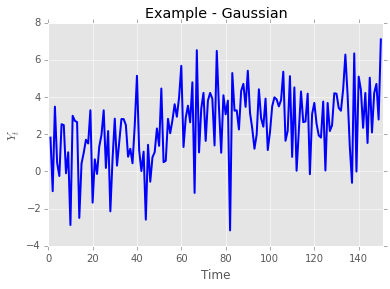

In [11]:
n = len(y)
plt.plot(np.arange(n) + 1, y, '-b', linewidth = 2)
plt.xlabel('Time')
plt.ylabel('$Y_t$')
plt.xlim([0, 151])
plt.title('Example - Gaussian')

In [12]:
theta_star_1, Ptran_star_1 = mcem_update(y = y, m = 1, family = "gaussian", tol = 0.01)

Convergence Reached


In [13]:
Tau_p_1, Theta_p_1, F_lag_sum_1, F_sum_1, log_f_y_1, log_m_1 = \
    model_fit(y = y, m = 1, vsim = 3000, burn = 1000, theta_star = theta_star_1, \
              Ptran_star = Ptran_star_1, c = 2., d = 100., family = "gaussian")

Posterior Sampling Finished Successfully.


First we observe that the MLE is quite close to the posterior means. Then we can extrapolate the most likely change point from the posterior samples as well. Further, one can easily obtain the maximized likelihood as well as the marginal likelihood. 

In [14]:
print "MLE", theta_star_1

MLE [ 1.1819  3.1157]


In [15]:
print "Posterior Means", Theta_p_1[1000:,].mean(axis = 0)

Posterior Means [ 1.1857  3.1189]


In [16]:
print "The posterior estimates for the change point is at time %.d."  \
    %(stats.mode(Tau_p_1[1000:,0])[0][0])

The posterior estimates for the change point is at time 53.


## Illustrative Example with Simulated Gaussian Time Series

In this illustrative example, we examined the performance of the algorithm in greater details. A Gaussian time series was simulated with two change points, located at time $50$ and $100$. The three distinct means are $1,3$ and $5$. The following plot helps visualize the time series. From the plot, we can sense the increasing values across time, however, it is hard to determine exactly where the change points are located from a first look.  

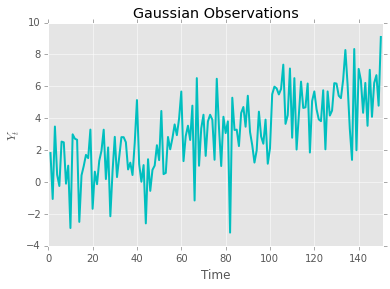

In [17]:
y = np.loadtxt('Data/data_gaussian')
n = len(y)
np.random.seed(1234)
plt.plot(np.arange(n) + 1, y, '-c', linewidth = 2)
plt.xlabel('Time')
plt.ylabel('$Y_t$')
plt.xlim([0, 151])
plt.title('Gaussian Observations')

### Model Comparisons

Below we fit three models $M_1$, $M_2$ and $M_3$, indexing models with $1$ to $3$ change points. All models initialize the MLE using MCEM and carried the MLEs in computing the marginal likelihood via MCMC.

In [18]:
# MCEM
n, m = len(y), 1
theta_star, Ptran_star = mcem_update(y, m, family = "gaussian", tol = 0.01)

Convergence Reached


In [19]:
# MCMC
vsim, burn = 7000, 1000
c, d = 2., 100.
Tau_p_1, Theta_p_1, F_lag_sum_1, F_sum_1, log_f_y_1, log_m_1 =  \
    model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d, family = "gaussian")

Posterior Sampling Finished Successfully.


In [20]:
# MCEM
n, m = len(y), 2
theta_star, Ptran_star = mcem_update(y, m, family = "gaussian", tol = 0.01)

Convergence Reached


In [21]:
# MCMC
vsim, burn = 7000, 1000
c, d = 2., 100.
Tau_p_2, Theta_p_2, F_lag_sum_2, F_sum_2, log_f_y_2, log_m_2 =  \
    model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d, family = "gaussian")

Posterior Sampling Finished Successfully.


In [22]:
# MCEM
n, m = len(y), 3
theta_star, Ptran_star = mcem_update(y, m, family = "gaussian", tol = 0.01)

Convergence Reached


In [23]:
# MCMC
vsim, burn = 7000, 1000
c, d = 2., 100.
Tau_p_3, Theta_p_3, F_lag_sum_3, F_sum_3, log_f_y_3, log_m_3 =  \
    model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d, family = "gaussian")

Posterior Sampling Finished Successfully.


Following the idea of the paper, we plotted the averaged marginal posterior density for the regimes of each observation from $M_1$ to $M_3$. We clearly see that $M_1$ and $M_3$ make ambiguous regime membership for quite a lot of time periods, and the change points are unclear. Among them, $M_2$ seemed to have better fit and claimed clear regime membership. We could infer that the first change point occurred at round time $50$ to $55$ while the second one at around time $100$. 

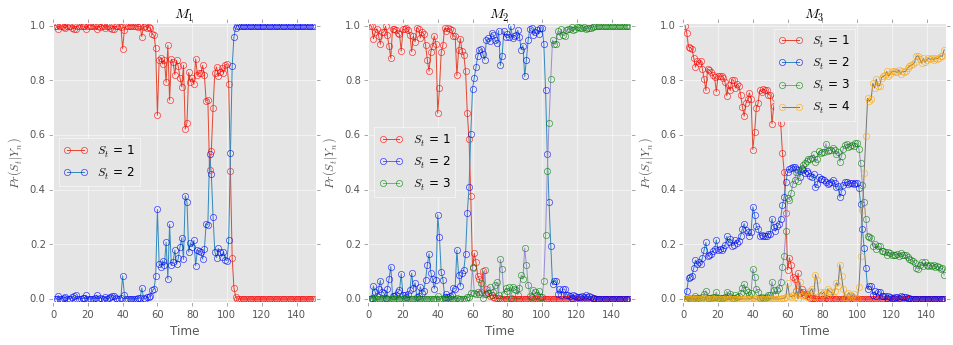

In [24]:
# Visualize change point for all models
time = np.arange(1, n + 1)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
PrS = F_sum_1 / float(vsim - burn)
plt.plot(time, PrS[:,0], "o-", label = "$S_t$ = 1", \
         markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "$S_t$ = 2", \
         markerfacecolor = "none", markeredgecolor = "blue")
plt.xlim([0, 151])
plt.ylim([-0.01, 1.01])
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(S_t|Y_n)$")
plt.title("$M_1$")

plt.subplot(1, 3, 2)
PrS = F_sum_2 / float(vsim - burn)
plt.plot(time, PrS[:,0], "o-", label = "$S_t$ = 1", \
         markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "$S_t$ = 2", \
         markerfacecolor = "none", markeredgecolor = "blue")
plt.plot(time, PrS[:,2], "o-", label = "$S_t$ = 3", \
         markerfacecolor = "none", markeredgecolor = "green")
plt.xlim([0, 151])
plt.ylim([-0.01, 1.01])
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(S_t|Y_n)$")
plt.title("$M_2$")

plt.subplot(1, 3, 3)
PrS = F_sum_3 / float(vsim - burn)
plt.plot(time, PrS[:,0], "o-", label = "$S_t$ = 1", \
         markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "$S_t$ = 2", \
         markerfacecolor = "none", markeredgecolor = "blue")
plt.plot(time, PrS[:,2], "o-", label = "$S_t$ = 3", \
         markerfacecolor = "none", markeredgecolor = "green")
plt.plot(time, PrS[:,3], "o-", label = "$S_t$ = 4", \
         markerfacecolor = "none", markeredgecolor = "orange")
plt.xlim([0, 151])
plt.ylim([-0.01, 1.01])
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(S_t|Y_n)$")
plt.title("$M_3$")

Formal inference on model selection are determined by Bayes factor, which is defined as:

$$BF_{rs}=\frac{m(Y_n|M_r)}{m(Y_n|M_s)}.$$

We summarized all the model evidence in the following table. The Bayes factor $B_{21}\approx 222$ and $B_{23}\approx 156$, providing strong evidence in favor of $M_2$. This conclusion also agrees with the values of the maximized log-likelihood.

In [25]:
table_gaussian = np.array([log_f_y_1, log_f_y_2, log_f_y_3, \
                           log_m_1, log_m_2, log_m_3]).reshape(2,3)
rownames = ["$M_1$", "$M_2$", "$M_3$"]
colnames = ["$\log f(Y_n|\phi^{*})$", "$\log m(Y_n)$"]
pd.DataFrame(np.around(table_gaussian, 3), colnames, rownames)

,$M_1$,$M_2$,$M_3$
$\log f(Y_n|\phi^{*})$,-319.900,-308.535,-314.983
$\log m(Y_n)$,-327.682,-322.500,-327.661


Next we make formal inference on the locations of the two change points. The following plot presents the posterior probability of locations of both change points. We see that the highest probabilities are at time $53$ and $100$, very close to the true values. 

The posterior estimates for change points 
 are at time 53 (with prob 0.180) and 100 (with prob 0.534)


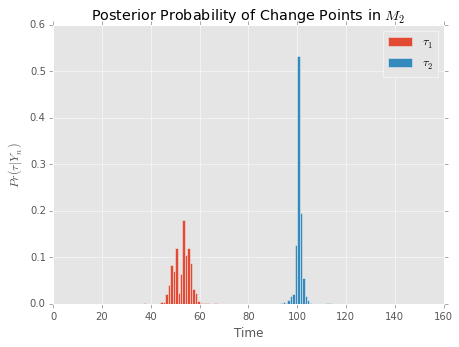

In [36]:
# Estimation of Change Points
plt.figure(figsize=(7, 5))
plt.hist(Tau_p_2[burn:,0], bins = n, range = (1, 151), normed = True, label = "$\\tau_1$")
plt.hist(Tau_p_2[burn:,1], bins = n, range = (1, 151), normed = True, label = "$\\tau_2$")
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(\\tau|Y_n)$")
plt.title("Posterior Probability of Change Points in $M_2$")
print "The posterior estimates for change points \n are at time %.d (with prob %.3f) and %.d (with prob %.3f)"  \
    %(stats.mode(Tau_p_2[burn:,0])[0][0], \
      stats.mode(Tau_p_2[burn:,0])[1][0] / float(vsim - burn),  \
      stats.mode(Tau_p_2[burn:,1])[0][0], \
      stats.mode(Tau_p_2[burn:,1])[1][0] / float(vsim - burn))

It is worth pointing out that the chains for model parameters have good mixing properties only in the correct model $M_2$. In either $M_1$ and $M_3$, these chains are quite "sticky", indicating insufficient exploration of the posterior parameter space. This is a direct consequence of model misspecification. 

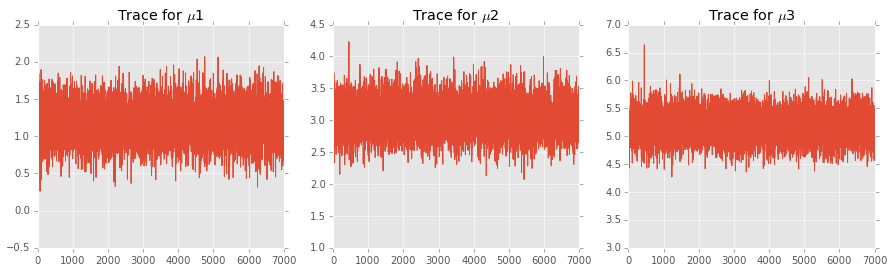

In [37]:
# MCMC diagnostics - Correct model
m = 2
plt.figure(figsize=(15, 4))
for i in range(m + 1):
    plt.subplot(1,3,i+1)
    plt.plot(Theta_p_2[:,i]);
    plt.title('Trace for $\mu$%d' % (i+1))

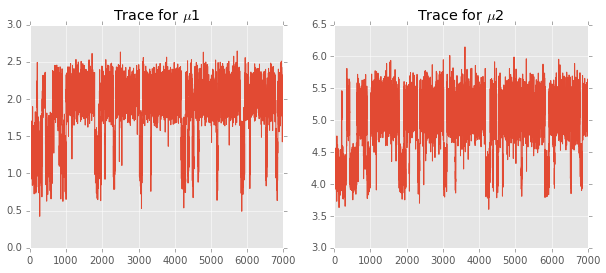

In [38]:
# MCMC diagnostics - Incorrect model, quite 'sticky'
m = 1
plt.figure(figsize=(10, 4))
for i in range(m + 1):
    plt.subplot(1,2,i+1)
    plt.plot(Theta_p_1[:,i]);
    plt.title('Trace for $\mu$%d' % (i+1))

In addition, we can use the model output to approximate the posterior densities of different regimes. The next plot overlays the posterior density with the flat (non-informative) prior density for each regime. The posterior means and standard deviations are summarized after the plot. We observe that the parameter estimates are almost equal to the truth with great precision (small standard deviation).  

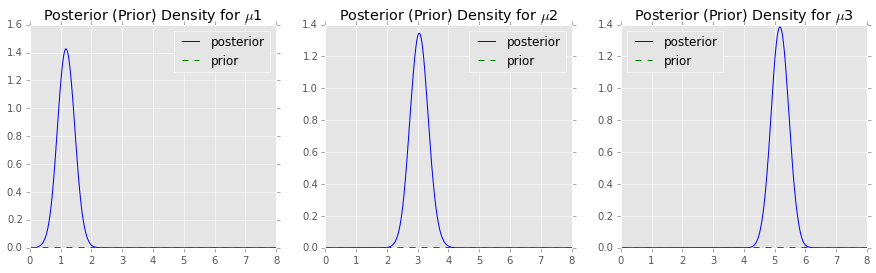

In [39]:
# density plots 
m = 2
plt.figure(figsize=(15, 4))
for i in range(m + 1):
    plt.subplot(1,3,i+1)
    density = stats.gaussian_kde(Theta_p_2[burn:,i])
    xs = np.linspace(0,8,800)
    density.covariance_factor = lambda : .5
    density._compute_covariance()
    plt.plot(xs,density(xs), 'b', label = "posterior")
    plt.plot(xs, stats.norm.pdf(xs, c, d), 'g--', label = "prior")
    plt.title('Posterior (Prior) Density for $\mu$%d' % (i+1))
    plt.legend(loc = "best")

In [40]:
table_estimate = np.concatenate((Theta_p_2[burn:,].mean(axis = 0), \
                                 Theta_p_2[burn:,].std(axis = 0))).reshape(2,3)
rownames = ["$\mu_1$", "$\mu_2$", "$\mu_3$"]
colnames = ["Posterior Mean", "Posterior Standard Deviation"]
pd.DataFrame(np.around(table_estimate, 3), colnames, rownames)

,$\mu_1$,$\mu_2$,$\mu_3$
Posterior Mean,1.177,3.051,5.175
Posterior Standard Deviation,0.249,0.266,0.255


### Alternative Algorithms

We discuss two alternative algorithms available in R. The first one is by Barry and Hartigan (1993), who used product partition distributions to model the stochastic process. The second one is a nonparametric model by Matteson and James (2013), whose method relies on a divergence measure of change in distributions. 

#### Barry and Hartigan (1993) - Product Partition Distributions

We use the R package "bcp", which approximated the product partition distribution method only for the Gaussian case (by the reference pages). Unique to the algorithm, it does not return specific number of change points and where they occur. Instead, it models each observation uniquely with different means. In order to make valid comparisons with Chib's method, we need to make inference based on the output evidence. The first plot shows the posterior means against time and their probabilities of a change occurring. We can see three distinct regimes with two jumping regions. 

Based on the two points with the highest probability of a change, we get the two change points to be at time $53$ and $100$, with probabilities $17.3\%$ and $51.4\%$, almost identical to the results from Chib's method. We then average the posterior means for each regime and found results close to both Chib's result and the tru values. Since we are clustering the points into two regimes, there are two versions to compute the posterior standard deviations, Monte Carlo (based on posterior samples) and model averaged (based on output posterior variances). We found that the model averaged one is close to Chib's method.

However, we should notice that this algorithm does not make final claims on how many change points and where they should be. Nor any model evidence is available from the output. But it indeed has flexibility in modeling for each single observations simultaneouly. 

In [41]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [42]:
from rpy2.robjects.packages import importr
utils = importr('utils')
# utils.install_packages('bcp')
# utils.install_packages('ecp')

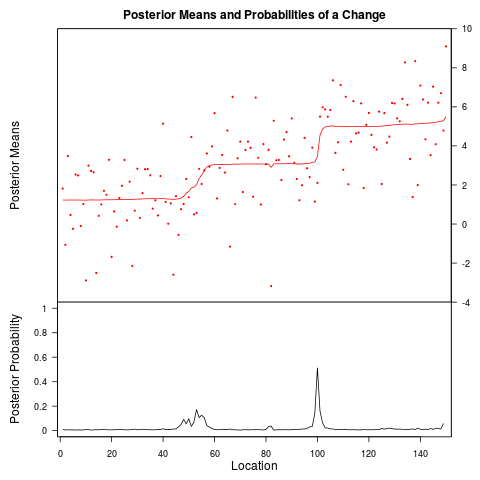

In [43]:
%%R -i y
library(bcp)
set.seed(1234)
fit = bcp(c(y), burnin = 1000, mcmc = 6000, return.mcmc = TRUE)
plot(fit)

In [44]:
%%R -i y
time = order(fit$posterior.prob, decreasing = TRUE)[c(2,1)]
pmeans = fit$posterior.mean
pprob = fit$posterior.prob
psamples = fit$mcmc.means[,-(1:1000)]
sd1 = sd(psamples[1:time[1], ])
sd2 = sd(psamples[(time[1]+1):time[2], ])
sd3 = sd(psamples[-(1:time[2]), ])
pstd = sqrt(fit$posterior.var)

cat("The estimated change points are at time", time, 
    ", with probabilities", round(pprob[time], 3), '\n')
cat("The posterior means for the three periods are", 
    round(c(mean(pmeans[1:time[1]]), mean(pmeans[(time[1]+1):time[2]]), 
            mean(pmeans[-(1:time[2])])), 3), '\n')
cat("The posterior standard deviations for the three periods are (Monte Carlo)", 
    round(c(sd1, sd2, sd3), 3), '\n')
cat("The posterior standard deviations for the three periods are (Model Averaged)", 
    round(c(mean(pstd[1:time[1]]), mean(pstd[(time[1]+1):time[2]]), 
            mean(pstd[-(1:time[2])])), 3), '\n')

The estimated change points are at time 53 100 , with probabilities 0.173 0.514 
The posterior means for the three periods are 1.314 3.042 5.066 
The posterior standard deviations for the three periods are (Monte Carlo) 0.318 0.366 0.319 
The posterior standard deviations for the three periods are (Model Averaged) 0.197 0.256 0.25 


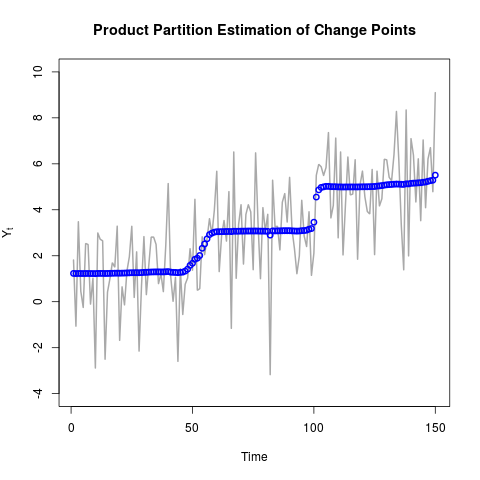

In [45]:
%%R -i y
plot(1:length(y), y, col = "darkgray", type = 'l', lwd = 2, ylim = c(-4, 10), xlab = "Time", 
     ylab = expression(Y[t]), main = "Product Partition Estimation of Change Points")
lines(1:length(y), c(fitted(fit)), type = 'p', col = "blue", lwd = 2)

#### Matteson and James (2013) - Nonparametric Multiple Change-point Analysis

Next we make use of an up-to-date nonparametric method developed by Matteson and James (2013). This method makes no parametric assumption and is not subject to the underlying data generating model. Permutation approaches are used to obtain evidence in claiming significant locations of change points. That is to say, this is a rather classical/frequentist method, compared to the previous two Bayesian techniques. The method uses a divergence metric to detect change in regimes, which could also somewhat arbitrary (since lots of other choices are available). 

We again found the same results as before in terms of the locations of the two change points. These are significant locations subject to permutational distributions. The final claims are made based on an old friend, the "p-values". We visualize the change point locations in the following plot.

In [46]:
%%R -i y
library(ecp)
set.seed(1234)
fit = e.divisive(matrix(y, length(y), 1), R = 499)
cat("The number of change points found is", fit$k.hat-1, 
    ", and they are at time", head(fit$estimates[-1], -1) - 1, '\n')

The number of change points found is 2 , and they are at time 53 100 


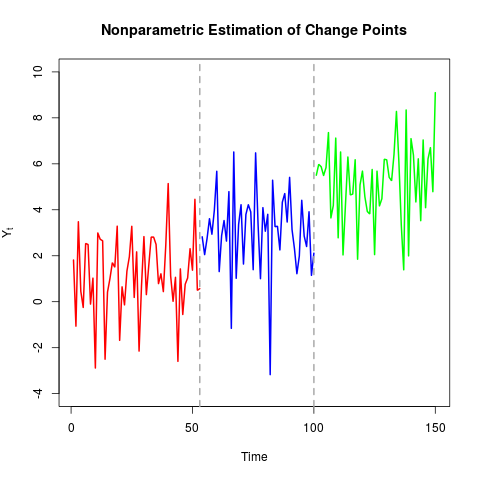

In [47]:
%%R -i y
state = fit$cluster
time = cumsum(c(sum(state == 1), sum(state == 2), sum(state == 3)))
plot(1:time[1], y[state == 1], type = 'l', col = "red", lwd = 2, 
     xlim = c(1, length(state)), 
     ylim = c(-4, 10), xlab = "Time", ylab = expression(Y[t]), 
     main = "Nonparametric Estimation of Change Points")
abline(v = time[1], lwd = 2, lty = 2, col = "darkgray")
lines((time[1] + 1):time[2], y[state == 2], type ='l', lwd = 2, col = "blue")
abline(v = time[2], lwd = 2, lty = 2, col = "darkgray")
lines((time[2] + 1):time[3], y[state == 3], type ='l', lwd = 2, col = "green")

## Analysis of Coal-mining Disasters Data

We now applied Chib's method to a real data set. This data is the much analyzed data containing the number of coal-mining disasters by year in Britain from $1851$ to $1962$ (Jarrett, 1979). The idea is model the underlying generating distribution as Poisson and detect possible change points. This data set is also analyzed by Chib and many others. We consider analyzing the data set to (1) confirm we can get similar results to Chib's application and (2) as a further demonstration of the method for non-Gaussian discrete distributions. 

By a first look, it is hard to infer the number of change points and their locations (the following barplot). We fit three models $M_0$, $M_1$ and $M_2$, corresponding to no change point, a single change point and two change points and compute their model evidence. Similar to the Gaussian case, the MLE for each model is computed by MCEM, and the MCMC is run for $7000$ iterations with the first $1000$ as burn-in. Suppose we use the conjugate Gamma($c, d$) prior for the Poisson mean, the marginal likelihood for $M_0$ can be derived as

$$m(Y_n|M_0)=\frac{1}{\prod_{t=1}^n y_t!}\frac{d^c}{(n+d)^{c+\sum_{t=1}^n y_t}}\frac{\Gamma(c+\sum_{t=1}^n y_t)}{\Gamma(c)}.$$

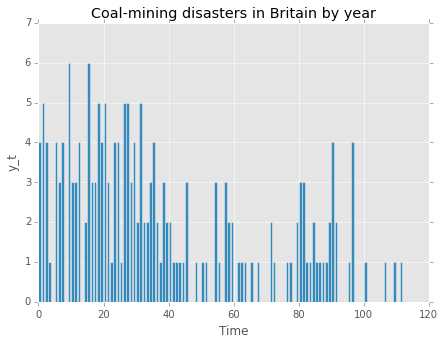

In [48]:
y = np.loadtxt('Data/data_poisson')
n = len(y)
np.random.seed(1234)
plt.figure(figsize=(7, 5))
plt.ylim([0, 7])
plt.bar(np.arange(112), y)
plt.xlabel('Time')
plt.ylabel('y_t')
plt.title('Coal-mining disasters in Britain by year')

### Model Fitting and Comparisons

In [49]:
# M_0
from math import lgamma, factorial
n, m = len(y), 0
c, d = 2.0, 1.0
y_bar = y.mean()
log_f_y_0 = np.sum(stats.poisson.logpmf(y, mu = y_bar))
log_m_0 = c*np.log(d) - (c + np.sum(y))*np.log(n + d) \
    - np.sum(np.log(np.vectorize(factorial)(y))) +  \
    lgamma(c + np.sum(y)) - lgamma(c)

In [50]:
# MCEM
n, m = len(y), 1
theta_star, Ptran_star = mcem_update(y, m, family = "poisson", tol = 0.01)

Convergence Reached


In [51]:
# MCMC
vsim, burn = 7000, 1000
c, d = 2., 1.
Tau_p_1, Theta_p_1, F_lag_sum_1, F_sum_1, log_f_y_1, log_m_1 =  \
    model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d, family = "poisson")

Posterior Sampling Finished Successfully.


In [52]:
# MCEM
n, m = len(y), 2
theta_star, Ptran_star = mcem_update(y, m, family = "poisson", tol = 0.01)

Convergence Reached


In [53]:
# MCMC
vsim, burn = 7000, 1000
c, d = 3., 1.
Tau_p_2, Theta_p_2, F_lag_sum_2, F_sum_2, log_f_y_2, log_m_2 =  \
    model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d, family = "poisson")

Posterior Sampling Finished Successfully.


In the following code, we plotted the averaged marginal posterior density for the regimes of each observation in $M1$ and $M2$. We are able to see that $M_1$ has more reasonable separation of two regimes and the change seemed happen at time $40$ to $45$.

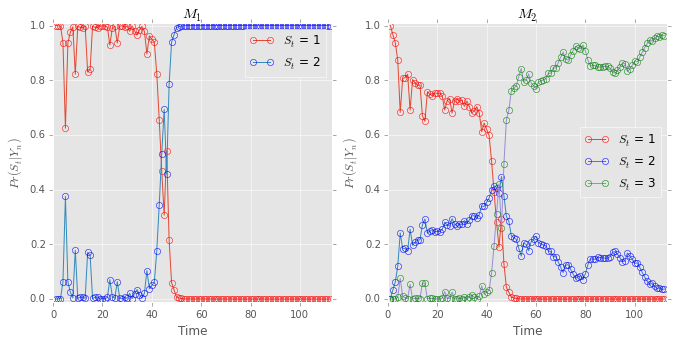

In [54]:
# Visualize change point for all models
time = np.arange(1, n + 1)
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
PrS = F_sum_1 / float(vsim - burn)
plt.plot(time, PrS[:,0], "o-", label = "$S_t$ = 1", \
         markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "$S_t$ = 2", \
         markerfacecolor = "none", markeredgecolor = "blue")
plt.xlim([0, 113])
plt.ylim([-0.01, 1.01])
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(S_t|Y_n)$")
plt.title("$M_1$")

plt.subplot(1, 2, 2)
PrS = F_sum_2 / float(vsim - burn)
plt.plot(time, PrS[:,0], "o-", label = "$S_t$ = 1", \
         markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "$S_t$ = 2", \
         markerfacecolor = "none", markeredgecolor = "blue")
plt.plot(time, PrS[:,2], "o-", label = "$S_t$ = 3", \
         markerfacecolor = "none", markeredgecolor = "green")
plt.xlim([0, 113])
plt.ylim([-0.01, 1.01])
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(S_t|Y_n)$")
plt.title("$M_2$")

We then infer the exact location of possible change points. If $M_1$ is the correct model ,then the change point is most likely to be at time $41$, and if $M_2$ is the correct one, then the change point most likely lies at time $36$ and $41$. By further looking at the Bayes factors, we are able to compute that

$$BF_{12}\approx 10,\qquad\qquad BF_{10}\approx 1.21\times 10^{12},$$

providing moderate and substantially strong evidence in preference of $M_1$ over $M_2$ and $M_0$. Following Chib's reasoning, $M_1$ is the appropriate model and the change point is most likely to occur at time $t=41$ (confirming Chib's exact same result, and the same conclusion with the results given by Carlin, 1992).

The posterior estimate for the change point is at time 41 (with prob 0.238).


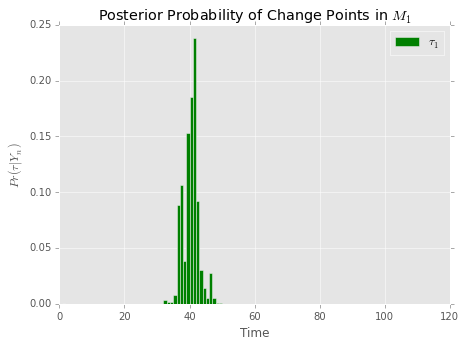

In [55]:
# Estimation of Change Points M_1
plt.figure(figsize=(7, 5))
plt.hist(Tau_p_1[burn:,0], bins = n, range = (1, 113), \
         normed = True, label = "$\\tau_1$", color = 'green')
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("$Pr(\\tau|Y_n)$")
plt.title("Posterior Probability of Change Points in $M_1$")
print "The posterior estimate for the change point is at time %.d (with prob %.3f)."  \
    %(stats.mode(Tau_p_1[burn:,0])[0][0], \
      stats.mode(Tau_p_1[burn:,0])[1][0] / float(vsim - burn))

The estimates for change points are at time 36 (with prob 0.096) and 41 (with prob 0.149)


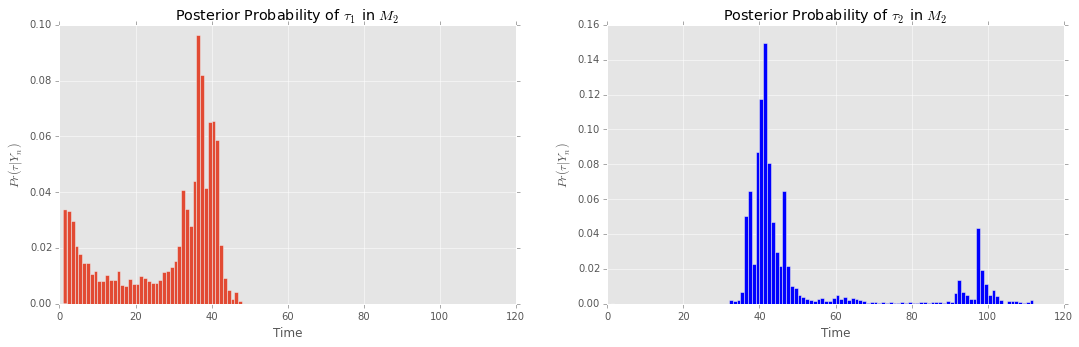

In [56]:
# Estimation of Change Points M_2
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.hist(Tau_p_2[burn:,0], bins = n, range = (1, 113), \
         normed = True, label = "$\\tau_1$")
plt.xlabel("Time")
plt.ylabel("$Pr(\\tau|Y_n)$")
plt.title("Posterior Probability of $\\tau_1$ in $M_2$")
plt.subplot(1, 2, 2)
plt.hist(Tau_p_2[burn:,1], bins = n, range = (1, 113), \
         normed = True, label = "$\\tau_2$", color = "blue")
plt.xlabel("Time")
plt.ylabel("$Pr(\\tau|Y_n)$")
plt.title("Posterior Probability of $\\tau_2$ in $M_2$")
print "The estimates for change points are at time %.d (with prob %.3f) and %.d (with prob %.3f)"  \
    %(stats.mode(Tau_p_2[burn:,0])[0][0], \
      stats.mode(Tau_p_2[burn:,0])[1][0] / float(vsim - burn),  \
      stats.mode(Tau_p_2[burn:,1])[0][0], \
      stats.mode(Tau_p_2[burn:,1])[1][0] / float(vsim - burn))

In [57]:
table_poisson = np.array([log_f_y_0, log_f_y_1, log_f_y_2, \
                          log_m_0, log_m_1, log_m_2]).reshape(2,3)
rownames = ["$M_0$", "$M_1$", "$M_2$"]
colnames = ["$\log f(Y_n|\phi^{*})$", "$\log m(Y_n)$"]
pd.DataFrame(np.around(table_poisson, 3), colnames, rownames)

,$M_0$,$M_1$,$M_2$
$\log f(Y_n|\phi^{*})$,-203.858,-176.903,-179.035
$\log m(Y_n)$,-206.207,-178.381,-180.636


Again, simlar to the simulation study, we are able to show good convergence of the chains, provide the posterior density plots, estimates and precision using the model output.

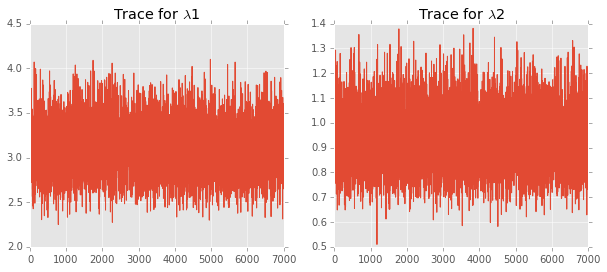

In [58]:
# MCMC diagnostics
m = 1
plt.figure(figsize=(10, 4))
for i in range(m + 1):
    plt.subplot(1,2,i+1)
    plt.plot(Theta_p_1[:,i]);
    plt.title('Trace for $\lambda$%d' % (i+1))

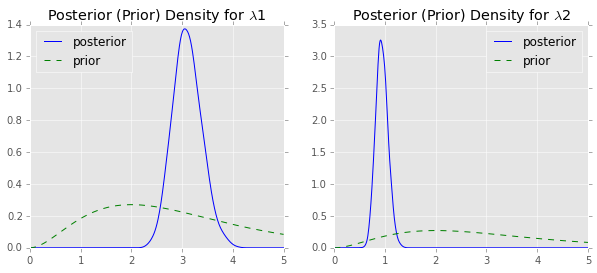

In [59]:
# density plots (reproduce the paper output)
plt.figure(figsize=(10, 4))
for i in range(m + 1):
    plt.subplot(1,2,i+1)
    density = stats.gaussian_kde(Theta_p_1[burn:,i])
    xs = np.linspace(0,5,500)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs), 'b', label = "posterior")
    plt.plot(xs, stats.gamma.pdf(xs, c, scale = 1.0/d), 'g--', label = "prior")
    plt.legend(loc = "best")
    plt.title('Posterior (Prior) Density for $\lambda$%d' % (i+1))

In the coal-mining data set, we are able to conclude that there exists one major change point, occuring at year $1891$. The number of disasters can be modelled via a Poisson distribution with mean around $3$ from year $1851$ to $1891$. After $1891$, the number of disasters are notably reduced, and approximated followed a Poisson distribution with mean close to $1$.

In [60]:
table_estimate = np.concatenate((Theta_p_1[burn:,].mean(axis = 0), \
                                 Theta_p_1[burn:,].std(axis = 0))).reshape(2,2)
rownames = ["$\lambda_1$", "$\lambda_2$"]
colnames = ["Posterior Mean", "Posterior Standard Deviation"]
pd.DataFrame(np.around(table_estimate, 3), colnames, rownames)

,$\lambda_1$,$\lambda_2$
Posterior Mean,3.100,0.938
Posterior Standard Deviation,0.284,0.118


### Implementation of Alternative Algorithms

The two previously mentioned alternative algorithms are implemented for the coal-mining data set. With the two alternative methods, we are able to conclude that there is only a single change point. However, the location is estimated to be at time $t=36$, different from Chib's result.

#### Barry and Hartigan (1993) - Product Partition Distributions

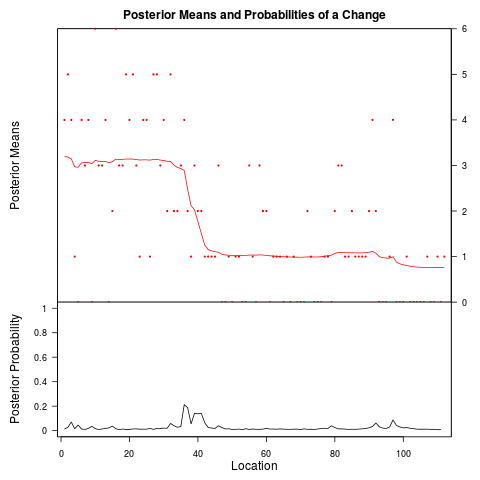

In [62]:
%%R -i y
library(bcp)
set.seed(1234)
fit = bcp(c(y), burnin = 1000, mcmc = 6000, return.mcmc = TRUE)
plot(fit)

In [63]:
%%R -i y
time = order(fit$posterior.prob, decreasing = TRUE)[1]
pmeans = fit$posterior.mean
pprob = fit$posterior.prob
psamples = fit$mcmc.means[,-(1:1000)]
sd1 = sd(psamples[1:time[1], ])
sd2 = sd(psamples[-(1:time[1]), ])
pstd = sqrt(fit$posterior.var)

cat("The estimated change points are at time", time, 
    ", with probabilities", round(pprob[time], 3), '\n')
cat("The posterior means for the three periods are", 
    round(c(mean(pmeans[1:time[1]]), mean(pmeans[-(1:time[1])])), 3), '\n')
cat("The posterior standard deviations for the three periods are (Monte Carlo)", 
    round(c(sd1, sd2), 3), '\n')
cat("The posterior standard deviations for the three periods are (Model Averaged)", 
    round(c(mean(pstd[1:time[1]]), mean(pstd[-(1:time[1])])), 3), '\n')

The estimated change points are at time 36 , with probabilities 0.213 
The posterior means for the three periods are 3.087 1.051 
The posterior standard deviations for the three periods are (Monte Carlo) 0.263 0.408 
The posterior standard deviations for the three periods are (Model Averaged) 0.226 0.236 


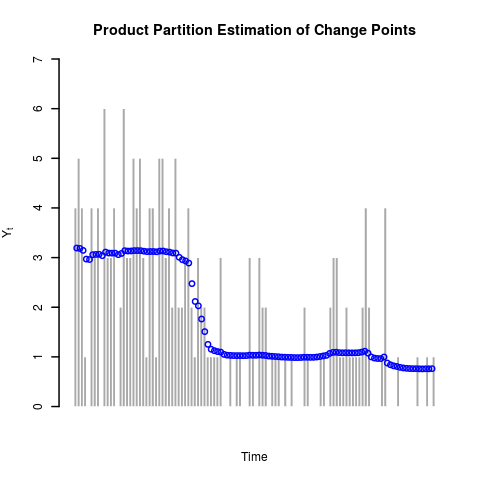

In [64]:
%%R -i y
barplot(y, col = "darkgray", width = 0.84, lwd = 2, 
        xlim = c(0, 113), ylim = c(0, 7), xlab = "Time", ylab = expression(Y[t]), 
        main = "Product Partition Estimation of Change Points", border = "white")
lines(1:length(y), c(fitted(fit)), type = 'p', col = "blue", lwd = 2)

#### Matterson and James (2013) - Nonparametric Multiple Change-point Analysis

In [65]:
%%R -i y
library(ecp)
set.seed(1234)
fit = e.divisive(matrix(y, length(y), 1), R = 499)
cat("The number of change points found is", fit$k.hat-1, 
    ", and they are at time", head(fit$estimates[-1], -1) - 1, '\n')

The number of change points found is 1 , and they are at time 36 


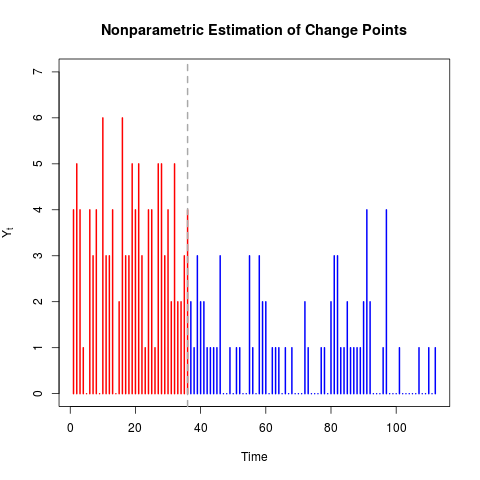

In [66]:
%%R -i y
state = fit$cluster
time = cumsum(c(sum(state == 1), sum(state == 2)))
plot(-1, xlim = c(1, length(state)), 
     ylim = c(0, 7), xlab = "Time", ylab = expression(Y[t]), 
     main = "Nonparametric Estimation of Change Points")
for(i in 1:time[1]){
    segments(i,0, i,y[i], lwd = 2, col = "red")
}
abline(v = time[1], lwd = 2, lty = 2, col = "darkgray")
for(j in (time[1]+1):time[2]){
    segments(j,0, j,y[j], lwd = 2, col = "blue")
}

## Discussion and Comparisons

In this project, we presented the core ideas of Chib's method in fitting and comparing multiple change-point models. This is a classic Bayesian fitting framework where Monte Carlo Markov Chain is used to obtain posterior samples in order to approximate the joint posterior densities of all parameters of interest. In the beginning, the naive code was programmed for a first implementation. After lining profiling and looking into the code more carefully, we are able to optimize the code using vectorization (also to reduce the object defined as well as repeated calculation). We compared the time used for each update using both versions of code and demonstrated improvement upon the naive version. We developed unit test (including edge cases where the transition probabilities is negative) to make sure the functions are executing correctly, returning desired quantities. Then we demonstrated how the code (module functions) work using a simple example. A detailed illustrative example with simulated Gaussian time series was presented to show how to analyze such time series data and detect change point (and to prove whether this algorithm can find the correct number and the location of the change points). Finally, we analyzed the real data on coal-mining disasters. Throughout the analysis, two alternative algorithms are also used and their results compared to Chib's method. We now offer two cents on the three algorithms. 

Chib's algorithm has several advantages. First, it is quite innovative at that time. By presenting the change-point problem in the framework of a Hidden Markov Model, the posterior sampling can be carried out by Gibbs steps with conjugate priors. The only messy part that requires innovative thinking and a bit of programming is to sample the hidden states/regimes. Previous methods resort to Metroplis-Hastings steps, but it is in general difficult to find a proposal distribution that works well. Second, the output is quite complete. The model fit comes along with the posterior samples for all parameters, including for the hidden states. The posterior distribution of the change points is simply a function of the hidden states, which can be easily calculated once we have a sample of the hidden states. Moreover, it offers solid model evidence (Bayes factor) for making inferences on exactly how many change points control the process under study. Third, the framework is flexible so that extensions to more complex models are quite straightforward (regression, nonparametric models).

However, each advantage comes with some disadvantages. Due to the nature of Hidden Markov Models, the forward-backward step is not easy to parallel, posing challenges to improving the speed of any single step. Besides, each MCMC step relies on its previous step, so simultaneous sampling all the posterior (as one would have done in common problems to save computation time) is impractical. So computation time is one drawback. Although we have improved the speed of the algorithm in Python, further improvement can possibly be made by programming in C, although we need to write customized sampling function for common parametric models. Second, obtaining model evidence for several models in Chib's method is expensive, since (1) multiple models need to be fit using the same algorithm (adding computation time) and (2) each fit requires a coordinate near the MLE obtained by MCEM (adding computation time). 

Compared to Chib's method, the two alternatives share some advantages and disadvantages. BH method (Barry and Hartigan, 1993) fit different means for each observation. In that regard, it is more general than Chib's method. But to make inferences on how many change points are available, we need to look at all the values and make subjective inferences. No model evidence is available from the algorithm so we cannot compare across models with different number of change points. And any inferences drawn for model comparisons are based on experiences. The R package is written in C and is quite efficient in time. A closer look at the algorithm indicates that they used a direct Markov sampling method that requires no recursive calculation. So it is just typical MCMC algorithm that would not expect to take longer than a fitting a Hidden Markov Model. The package can now only accommodate Gaussian models, and we indeed see the same conclusions drawn as Chib's method in the illustrative example. But different conclusions on the location of change point was reached in analyzing the Poisson coal-mining data. 

The nonparametric method (MJ method) developed recently by Matteson and James (2013) presents a completely different inference paradigm where classical p-value and permutation-based inference are used together to determine the change point locations and quantities. It is also quite fast but the inference is based on a one-time fit and selection of models are based on p-values where one need to determine the nominal type I error rate. So the inference techniques are completely different from the Bayesian framework. We do not offer a long discussion among two paradigms here but only acknowledge that each has their merits and drawbacks and cautions need to be taken in interpreting the results. The change points are identical using MJ method and Chib's method in analyzing Gaussian data, but slighltly different in analyzing the coal-mining data.